# Electronic Structure Calculations using Generalized Ising Hamiltonians

Your final task is to calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$$ H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j + \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k + \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l + \cdots $$

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided to you by the `read_generalized_ising_hamiltonian` function below.

These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [34]:
import numpy as np

from abstract_ising import AbstractIsing
from ising_animator import IsingAnimator
import matplotlib.pyplot as plt
import itertools as it
import os
%matplotlib inline

In [23]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [24]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

First, you must write a class that describes the Generalized Ising Model given the arrays containing the
 Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration
 (see the previous tasks for inspiration), as well as a function which computes the change in energy resulting from
 a single-spin-flip (you could of course use the naive approach and simply compute the energy of two spin configurations
  and subtract one from the other).

In [29]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters

class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, terms):
        self.terms = terms
        for t0, t1 in zip(terms, terms[1:]):
            if len(t1.shape) < len(t0.shape):
                raise ValueError('The terms have not been provided in the right order. Please provide them in order of '
                                 'increasing dimension')

        self.num_spins = terms[1].shape[0]
        self.spins = 2 * (np.random.rand(self.num_spins) < 0.5) - 1
    
    def energy(self):
        energy = 0
        for dim, term in enumerate(self.terms):
            prog = []
            for d in range(dim):
                prog.extend([np.roll(self.spins, d), [d]])
            prog.extend([term, list(range(dim))])
            energy += np.einsum(*prog)
        return energy
    
    def energy_diff(self, *coords):
        #naieve approach for now
        e0 = self.energy()
        self.spins[coords] *= -1
        e1 = self.energy()
        diff = e1 - e0
        self.spins[coords] *= -1
        return diff
    
    def rand_site(self):
        return [np.random.randint(self.num_spins)]

Next you'll run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [30]:
terms = [E0, h, J, K, L]
hydrogen = GeneralizedIsingModel(terms)
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = hydrogen.mc_step(T=1)

    if t % 50 == 0:
        print(E)

-1.147398372849702
0.20276959924483284
0.1316020749198472
-1.224913679704077
0.04881366487728034
-0.7653913281129656
-1.147398372849702
1.0944898990894536
-0.1792374454919034
-0.4442170159184656
0.2027695992448329
-0.33319337985945596
-1.147398372849702
0.1316020749198472
0.04881366487728034
-0.8429066349673406
0.7124828543527175
-0.8429066349673406
-0.33319337985945596
-1.224913679704077


Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

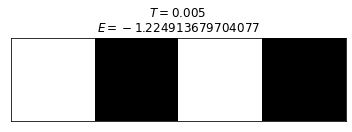

In [36]:
# logarithmic cooling
# https://ieeexplore.ieee.org/document/4767596
# t = np.arange(1, 500)
# c = 500
# T = c / (np.log2(t + 1))

def exp_schedule(N: int = 500, T_i: float = 100, T_f = 0.005):
    t = np.arange(N+1)
    T = T_i * ((T_f/T_i) ** (t/N))
    return T

# Hoffman and Salomon
# https://iopscience.iop.org/article/10.1088/0305-4470/23/15/023/pdf
# t = np.arange(2, 1000000, 2000)
# T = (4.52 - 1) / np.log(t)
# print(T)


terms = [E0, h, J, K, L]
hydrogen = GeneralizedIsingModel(terms)
T = exp_schedule()
animator = IsingAnimator(hydrogen)
animator.run_animation(T)

In [42]:
def simulated_anneal(ising, T):
    for t in T:
        energy = ising.mc_step(t)
    print('MC energy: {}'.format(energy))
    return energy

Finally, iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [38]:
terms = [E0, h, J, K, L]
hydrogen = GeneralizedIsingModel(terms)

def loop_over_spins(ising: AbstractIsing):
    gs_energy = np.inf
    configs = it.product((-1, 1), repeat=ising.num_spins)

    for spins in configs:
        ising.spins =  list(spins)
        current_energy = ising.energy()
        if current_energy < gs_energy:
            gs_energy = current_energy
    print('Ground state energy: {}'.format(gs_energy))
    return gs_energy

loop_over_spins(hydrogen)

Ground state energy: -1.224913679704077


-1.224913679704077

Now, clean up your code a little, and write a for-loop that iterates over all the different values of the Hydrogen seperation distance $R$ available in the `hamiltonians` directory. 

For each $R$ you must:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy
- Compare the two results

In [53]:
def gse_step(f_name: str):
    E0, h, J, K, L = read_generalized_ising_hamiltonian(f_name)
    terms = [E0, h, J, K, L]
    hydrogen = GeneralizedIsingModel(terms)
    schedule = exp_schedule()
    mc_energy = simulated_anneal(hydrogen, schedule)
    gs_energy = loop_over_spins(hydrogen)
    accuracy = 100 - ((gs_energy - mc_energy) / gs_energy * 100)
    print('Accuracy = {}%\n'.format(accuracy))

for f_path in [os.path.join('./hamiltonians/', x) for x in os.listdir('./hamiltonians/')]:
    gse_step(f_path)

MC energy: -0.963715530998402
Ground state energy: -0.963715530998402
Accuracy = 100.0%

MC energy: -0.9364306498270368
Ground state energy: -0.9364306498270368
Accuracy = 100.0%

MC energy: -1.1123189985565756
Ground state energy: -1.1123189985565756
Accuracy = 100.0%

MC energy: -1.1559401288998625
Ground state energy: -1.1559401288998625
Accuracy = 100.0%

MC energy: -1.033407690893829
Ground state energy: -1.033407690893829
Accuracy = 100.0%

MC energy: -0.95251125641518
Ground state energy: -0.95251125641518
Accuracy = 100.0%

MC energy: -0.9355963463412932
Ground state energy: -0.9355963463412932
Accuracy = 100.0%

MC energy: -1.0703883929861222
Ground state energy: -1.0703883929861222
Accuracy = 100.0%

MC energy: -0.9336434560990403
Ground state energy: -0.934973716316891
Accuracy = 99.85772218035274%

MC energy: -0.9391348485310812
Ground state energy: -0.9391348485310812
Accuracy = 100.0%

MC energy: -1.1962965239472774
Ground state energy: -1.1962965239472774
Accuracy = 100.

We see here that the MC annealer works quite well, apart from the cases where there is a small separation between the
 ground state and first excited state, here the accuracy dips slightly.


